# Hit Song Recipe Analysis: What Makes Songs Popular?

## Analysis Goals
Discover the specific combinations of features that create hit songs:

1. **Hit Song Examples**
   - Track names and artists
   - BPM and energy levels
   - Genre context

2. **Success Patterns**
   - What combinations work best
   - Genre-specific examples
   - Real song examples

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_style('whitegrid')

In [3]:
# Load data
sheet_url = "https://docs.google.com/spreadsheets/d/1ae96nZRL_kJWb_EEv2avxMOgGClvyc77SpY-VBqVGiY/edit#gid=1052928543"
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_export_url)

# Create BPM ranges
bpm_ranges = pd.cut(df['tempo'], 
                    bins=[0, 80, 100, 120, 140, 160, 200],
                    labels=['<80', '80-100', '100-120', '120-140', '140-160', '>160'])
df['bpm_range'] = bpm_ranges

# Define hit threshold (top 25%)
hit_threshold = df['track_popularity'].quantile(0.75)
df['is_hit'] = df['track_popularity'] >= hit_threshold

# Function to get example hit songs
def get_hit_examples(data, n=5):
    hits = data[data['is_hit']].sort_values('track_popularity', ascending=False)
    examples = hits[['track_name', 'track_artist', 'track_popularity', 
                    'tempo', 'energy', 'danceability']].head(n)
    return examples

# Analyze hits by BPM range
print("Hit Song Examples by BPM Range:")
for bpm_range in bpm_ranges.unique():
    range_data = df[df['bpm_range'] == bpm_range]
    hit_rate = range_data['is_hit'].mean() * 100
    examples = get_hit_examples(range_data)
    
    print(f"\nBPM Range: {bpm_range}")
    print(f"Hit Rate: {hit_rate:.1f}%")
    print("\nTop Hit Examples:")
    print(examples.to_string(index=False))
    print("-" * 80)

Hit Song Examples by BPM Range:

BPM Range: 80-100
Hit Rate: 27.2%

Top Hit Examples:
  track_name   track_artist  track_popularity  tempo  energy  danceability
Dance Monkey    Tones and I               100 98.027   0.588         0.824
    Memories       Maroon 5                98 91.019   0.320         0.764
        Vete      Bad Bunny                93 91.976   0.672         0.886
Lucid Dreams     Juice WRLD                92 83.903   0.566         0.511
   Fantasias Rauw Alejandro                92 94.004   0.703         0.879
--------------------------------------------------------------------------------

BPM Range: 100-120
Hit Rate: 27.3%

Top Hit Examples:
               track_name        track_artist  track_popularity   tempo  energy  danceability
                  ROXANNE      Arizona Zervas                99 116.735   0.601         0.621
                  The Box         Roddy Ricch                98 116.971   0.586         0.896
                     Tusa             KAROL G 

## Genre-Specific Hit Patterns

In [4]:
# Analyze hits by genre
print("Hit Song Examples by Genre:")
for genre in df['playlist_subgenre'].unique():
    genre_data = df[df['playlist_subgenre'] == genre]
    if len(genre_data) < 5:  # Skip genres with few songs
        continue
        
    print(f"\nGenre: {genre}")
    
    # Find most successful BPM range
    success_by_bpm = genre_data.groupby('bpm_range')['is_hit'].mean()
    best_bpm = success_by_bpm.idxmax()
    best_rate = success_by_bpm.max() * 100
    
    print(f"Most Successful BPM Range: {best_bpm} (Hit Rate: {best_rate:.1f}%)")
    
    # Show examples from best BPM range
    best_examples = get_hit_examples(genre_data[genre_data['bpm_range'] == best_bpm])
    print("\nTop Hit Examples:")
    print(best_examples.to_string(index=False))
    print("-" * 80)

Hit Song Examples by Genre:

Genre: post-teen pop
Most Successful BPM Range: <80 (Hit Rate: 70.3%)

Top Hit Examples:
                                    track_name      track_artist  track_popularity  tempo  energy  danceability
                           HIGHEST IN THE ROOM      Travis Scott                94 76.469   0.427         0.598
                     Hate Me (with Juice WRLD)    Ellie Goulding                88 75.025   0.768         0.657
If The World Was Ending (feat. Julia Michaels)           JP Saxe                88 75.801   0.473         0.464
                                          July        Noah Cyrus                88 72.541   0.186         0.708
                                          Ride Twenty One Pilots                81 74.989   0.713         0.645
--------------------------------------------------------------------------------

Genre: latin hip hop
Most Successful BPM Range: <80 (Hit Rate: 37.5%)

Top Hit Examples:
         track_name    track_artist  tr

/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_94419/2751518175.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_bpm = genre_data.groupby('bpm_range')['is_hit'].mean()
/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_94419/2751518175.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_bpm = genre_data.groupby('bpm_range')['is_hit'].mean()
/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_94419/2751518175.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

## Hit Song Recipes by Genre

In [6]:
# Calculate genre-specific recipes
genre_recipes = {}
for genre in df['playlist_subgenre'].unique():
    genre_hits = df[(df['playlist_subgenre'] == genre) & df['is_hit']]
    if len(genre_hits) < 5:
        continue
        
    recipe = {
        'bpm': f"{genre_hits['tempo'].mean():.0f} ± {genre_hits['tempo'].std():.0f}",
        'energy': f"{genre_hits['energy'].mean():.2f} ± {genre_hits['energy'].std():.2f}",
        'danceability': f"{genre_hits['danceability'].mean():.2f} ± {genre_hits['danceability'].std():.2f}",
        'example_songs': get_hit_examples(genre_hits, n=3)
    }
    genre_recipes[genre] = recipe

# Print recipes
print("Hit Song Recipes by Genre:")
for genre, recipe in genre_recipes.items():
    print(f"\n{genre.upper()} HITS:")
    print(f"BPM: {recipe['bpm']}")
    print(f"Energy: {recipe['energy']}")
    print(f"Danceability: {recipe['danceability']}")
    print("\nExample Hit Songs:")
    print(recipe['example_songs'].to_string(index=False))
    print("-" * 80)

Hit Song Recipes by Genre:

POST-TEEN POP HITS:
BPM: 122 ± 28
Energy: 0.70 ± 0.16
Danceability: 0.65 ± 0.13

Example Hit Songs:
     track_name track_artist  track_popularity   tempo  energy  danceability
   Dance Monkey  Tones and I               100  98.027   0.588         0.824
        Circles  Post Malone                98 120.042   0.762         0.695
Don't Start Now     Dua Lipa                97 123.941   0.793         0.794
--------------------------------------------------------------------------------

LATIN HIP HOP HITS:
BPM: 122 ± 32
Energy: 0.72 ± 0.14
Danceability: 0.71 ± 0.12

Example Hit Songs:
                           track_name    track_artist  track_popularity   tempo  energy  danceability
                              ROXANNE  Arizona Zervas                99 116.735   0.601         0.621
Own It (feat. Ed Sheeran & Burna Boy)         Stormzy                88 104.000   0.781         0.817
                             Believer Imagine Dragons                88 124.

## Success Rate Analysis

/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_94419/2618738421.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  success_matrix = df.pivot_table(


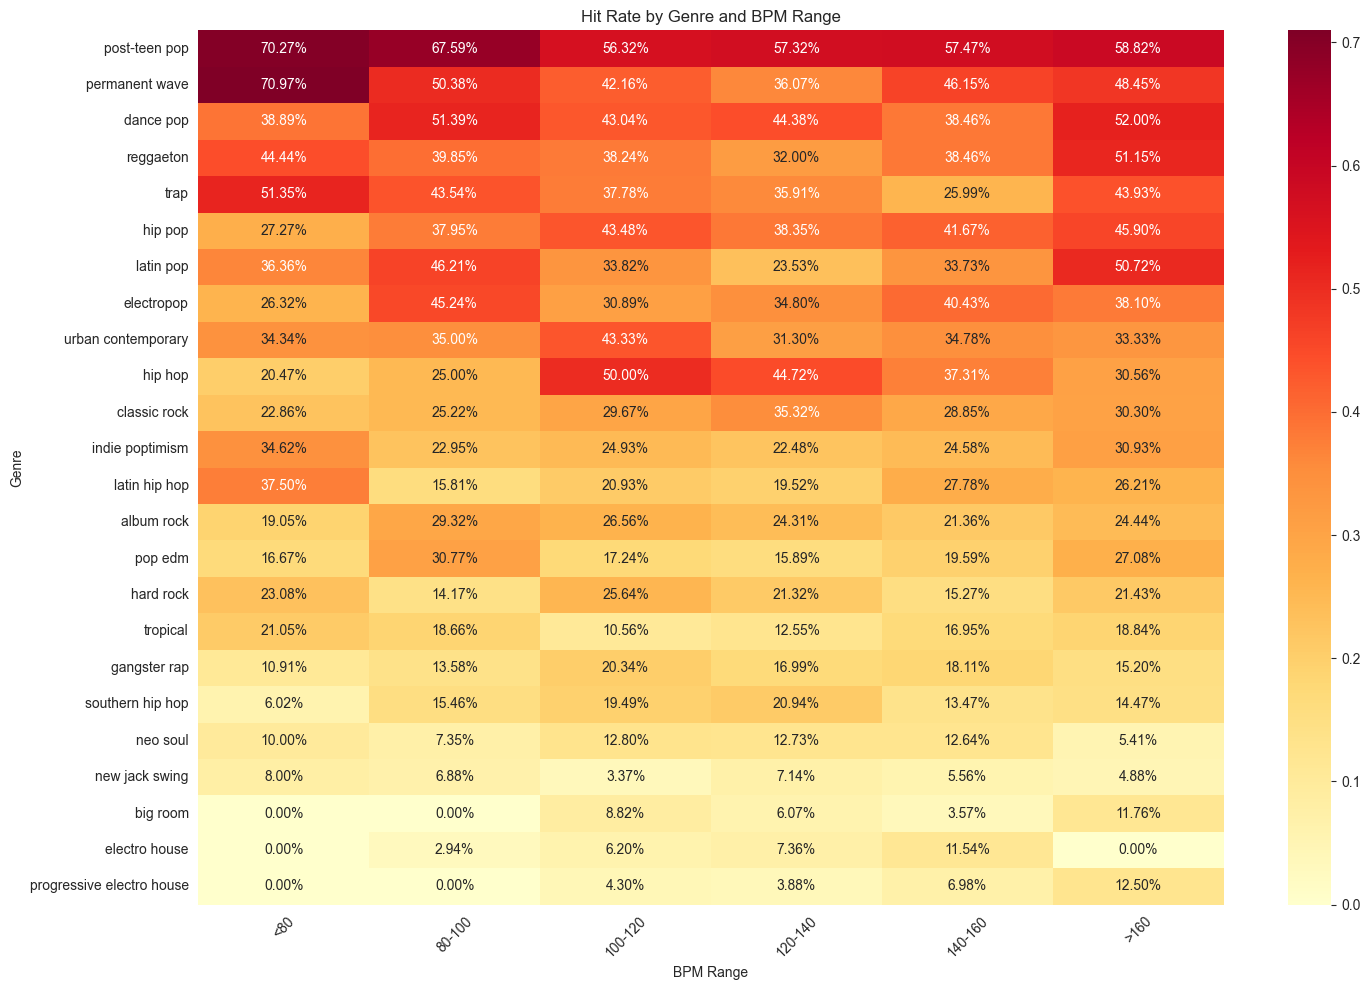


Example Hits from Most Successful Genre-BPM Combinations:

<80 at permanent wave BPM (Hit Rate: 71.0%)
Empty DataFrame
Columns: [track_name, track_artist, track_popularity, tempo, energy, danceability]
Index: []

<80 at post-teen pop BPM (Hit Rate: 70.3%)
Empty DataFrame
Columns: [track_name, track_artist, track_popularity, tempo, energy, danceability]
Index: []

80-100 at post-teen pop BPM (Hit Rate: 67.6%)
Empty DataFrame
Columns: [track_name, track_artist, track_popularity, tempo, energy, danceability]
Index: []

>160 at post-teen pop BPM (Hit Rate: 58.8%)
Empty DataFrame
Columns: [track_name, track_artist, track_popularity, tempo, energy, danceability]
Index: []

140-160 at post-teen pop BPM (Hit Rate: 57.5%)
Empty DataFrame
Columns: [track_name, track_artist, track_popularity, tempo, energy, danceability]
Index: []


In [ ]:
{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Hit Song Recipe Analysis: What Makes Songs Popular?\n",
    "\n",
    "## Analysis Goals\n",
    "Discover the specific combinations of features that create hit songs:\n",
    "\n",
    "1. **Hit Song Examples**\n",
    "   - Track names and artists\n",
    "   - BPM and energy levels\n",
    "   - Genre context\n",
    "\n",
    "2. **Success Patterns**\n",
    "   - What combinations work best\n",
    "   - Genre-specific examples\n",
    "   - Real song examples"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Import libraries\n",
    "import pandas as pd\n",
    "import numpy as np\n",
    "import matplotlib.pyplot as plt\n",
    "import seaborn as sns\n",
    "\n",
    "# Configure visualizations\n",
    "plt.style.use('seaborn')\n",
    "plt.rcParams['figure.figsize'] = [12, 6]\n",
    "sns.set_style('whitegrid')"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Load data\n",
    "sheet_url = \"https://docs.google.com/spreadsheets/d/1ae96nZRL_kJWb_EEv2avxMOgGClvyc77SpY-VBqVGiY/edit#gid=1052928543\"\n",
    "csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')\n",
    "df = pd.read_csv(csv_export_url)\n",
    "\n",
    "# Create BPM ranges\n",
    "bpm_ranges = pd.cut(df['tempo'], \n",
    "                    bins=[0, 80, 100, 120, 140, 160, 200],\n",
    "                    labels=['<80', '80-100', '100-120', '120-140', '140-160', '>160'])\n",
    "df['bpm_range'] = bpm_ranges\n",
    "\n",
    "# Define hit threshold (top 25%)\n",
    "hit_threshold = df['track_popularity'].quantile(0.75)\n",
    "df['is_hit'] = df['track_popularity'] >= hit_threshold\n",
    "\n",
    "# Function to get example hit songs\n",
    "def get_hit_examples(data, n=5):\n",
    "    hits = data[data['is_hit']].sort_values('track_popularity', ascending=False)\n",
    "    examples = hits[['track_name', 'track_artist', 'track_popularity', \n",
    "                    'tempo', 'energy', 'danceability']].head(n)\n",
    "    return examples\n",
    "\n",
    "# Analyze hits by BPM range\n",
    "print(\"Hit Song Examples by BPM Range:\")\n",
    "for bpm_range in bpm_ranges.unique():\n",
    "    range_data = df[df['bpm_range'] == bpm_range]\n",
    "    hit_rate = range_data['is_hit'].mean() * 100\n",
    "    examples = get_hit_examples(range_data)\n",
    "    \n",
    "    print(f\"\\nBPM Range: {bpm_range}\")\n",
    "    print(f\"Hit Rate: {hit_rate:.1f}%\")\n",
    "    print(\"\\nTop Hit Examples:\")\n",
    "    print(examples.to_string(index=False))\n",
    "    print(\"-\" * 80)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Genre-Specific Hit Patterns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Analyze hits by genre\n",
    "print(\"Hit Song Examples by Genre:\")\n",
    "for genre in df['playlist_subgenre'].unique():\n",
    "    genre_data = df[df['playlist_subgenre'] == genre]\n",
    "    if len(genre_data) < 5:  # Skip genres with few songs\n",
    "        continue\n",
    "        \n",
    "    print(f\"\\nGenre: {genre}\")\n",
    "    \n",
    "    # Find most successful BPM range\n",
    "    success_by_bpm = genre_data.groupby('bpm_range')['is_hit'].mean()\n",
    "    best_bpm = success_by_bpm.idxmax()\n",
    "    best_rate = success_by_bpm.max() * 100\n",
    "    \n",
    "    print(f\"Most Successful BPM Range: {best_bpm} (Hit Rate: {best_rate:.1f}%)\")\n",
    "    \n",
    "    # Show examples from best BPM range\n",
    "    best_examples = get_hit_examples(genre_data[genre_data['bpm_range'] == best_bpm])\n",
    "    print(\"\\nTop Hit Examples:\")\n",
    "    print(best_examples.to_string(index=False))\n",
    "    print(\"-\" * 80)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Hit Song Recipes by Genre"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Calculate genre-specific recipes\n",
    "genre_recipes = {}\n",
    "for genre in df['playlist_subgenre'].unique():\n",
    "    genre_hits = df[(df['playlist_subgenre'] == genre) & df['is_hit']]\n",
    "    if len(genre_hits) < 5:\n",
    "        continue\n",
    "        \n",
    "    recipe = {\n",
    "        'bpm': f\"{genre_hits['tempo'].mean():.0f} ± {genre_hits['tempo'].std():.0f}\",\n",
    "        'energy': f\"{genre_hits['energy'].mean():.2f} ± {genre_hits['energy'].std():.2f}\",\n",
    "        'danceability': f\"{genre_hits['danceability'].mean():.2f} ± {genre_hits['danceability'].std():.2f}\",\n",
    "        'example_songs': get_hit_examples(genre_hits, n=3)\n",
    "    }\n",
    "    genre_recipes[genre] = recipe\n",
    "\n",
    "# Print recipes\n",
    "print(\"Hit Song Recipes by Genre:\")\n",
    "for genre, recipe in genre_recipes.items():\n",
    "    print(f\"\\n{genre.upper()} HITS:\")\n",
    "    print(f\"BPM: {recipe['bpm']}\")\n",
    "    print(f\"Energy: {recipe['energy']}\")\n",
    "    print(f\"Danceability: {recipe['danceability']}\")\n",
    "    print(\"\\nExample Hit Songs:\")\n",
    "    print(recipe['example_songs'].to_string(index=False))\n",
    "    print(\"-\" * 80)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Success Rate Analysis"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Analyze success patterns by genre and BPM\n",
    "success_patterns = []\n",
    "\n",
    "for genre in df['playlist_subgenre'].unique():\n",
    "    genre_data = df[df['playlist_subgenre'] == genre]\n",
    "    if len(genre_data) < 5:  # Skip genres with few songs\n",
    "        continue\n",
    "        \n",
    "    for bpm_range in bpm_ranges.unique():\n",
    "        range_data = genre_data[genre_data['bpm_range'] == bpm_range]\n",
    "        if len(range_data) < 3:  # Skip ranges with few songs\n",
    "            continue\n",
    "            \n",
    "        hit_rate = range_data['is_hit'].mean()\n",
    "        if hit_rate > 0:\n",
    "            success_patterns.append({\n",
    "                'genre': genre,\n",
    "                'bpm_range': bpm_range,\n",
    "                'hit_rate': hit_rate,\n",
    "                'song_count': len(range_data)\n",
    "            })\n",
    "\n",
    "# Convert to DataFrame and sort by hit rate\n",
    "success_df = pd.DataFrame(success_patterns).sort_values('hit_rate', ascending=False)\n",
    "\n",
    "# Create heatmap\n",
    "plt.figure(figsize=(15, 10))\n",
    "heatmap_data = success_df.pivot(index='genre', columns='bpm_range', values='hit_rate').fillna(0)\n",
    "sns.heatmap(heatmap_data, annot=True, fmt='.2%', cmap='YlOrRd')\n",
    "plt.title('Hit Rate by Genre and BPM Range')\n",
    "plt.xlabel('BPM Range')\n",
    "plt.ylabel('Genre')\n",
    "plt.xticks(rotation=45)\n",
    "plt.tight_layout()\n",
    "plt.show()\n",
    "\n",
    "# Print top success patterns with example songs\n",
    "print(\"\\nMost Successful Genre-BPM Combinations:\")\n",
    "for _, pattern in success_df.head(10).iterrows():\n",
    "    genre = pattern['genre']\n",
    "    bpm_range = pattern['bpm_range']\n",
    "    hit_rate = pattern['hit_rate']\n",
    "    \n",
    "    print(f\"\\n{genre} at {bpm_range} BPM (Hit Rate: {hit_rate:.1%})\")\n",
    "    examples = get_hit_examples(\n",
    "        df[(df['playlist_subgenre'] == genre) & (df['bpm_range'] == bpm_range)],\n",
    "        n=3\n",
    "    )\n",
    "    if not examples.empty:\n",
    "        print(\"Example Hit Songs:\")\n",
    "        for _, song in examples.iterrows():\n",
    "            print(f\"{song['track_name']} by {song['track_artist']}\")\n",
    "            print(f\"Popularity: {song['track_popularity']}, \"\n",
    "                  f\"BPM: {song['tempo']:.0f}, \"\n",
    "                  f\"Energy: {song['energy']:.2f}, \"\n",
    "                  f\"Danceability: {song['danceability']:.2f}\")\n",
    "    print(\"-\" * 80)"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.8.0"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 4
}
